### Data-driven prediction of battery cycle life and knee-point

Kristen A. Severson et al., Data-driven prediction of battery cycle life before capacity degradation, Nature Energy, Vol. 4, 2019, 383-391, https://doi.org/10.1038/s41560-019-0356-8

Kristen A. Severson et al., Data-driven prediction of battery cycle life before capacity degradation, Supplementary Information, Nature Energy, Vol. 4, 2019.

In [1]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [2]:
# Scipy
from scipy.stats import pearsonr
from scipy.signal import medfilt
from scipy.integrate import simpson

In [3]:
# Scikit learn
from sklearn import svm
from sklearn.linear_model import ElasticNet, TweedieRegressor, ARDRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

In [4]:
try:
    import shap
except ImportError:
    print('Warning: SHAP library is not installed.')
    shap_analysis = False

In [5]:
from processing import (# Import local functions.
    import_dataset, 
    get_cell_stats, get_data_array_stats, 
    process_multiple_deltas,
    filter_signal, interpolate_signal, 
    bacon_watts_model, double_bacon_watts_model, 
    fit_bacon_watts_model, 
    get_features_targets_from_data,
    get_grid_values, run_regression,
)

In [6]:
sns.set_theme(context='paper', style='white', font_scale=1.1, palette='deep')
sns.set_style('ticks', {'xtick.direction':'in', 'ytick.direction':'in'})

### Import dataset

In [7]:
# NOTE: Running this cell can take some time.
path = os.path.dirname('/home/ps/Documents/Batteries/Data/')  # EDIT HERE
matlab_file = '2018-02-20_batchdata_updated_struct_errorcorrect.mat'
file_path = os.path.join(path, matlab_file)
bat_dict = import_dataset(file_path)

In [8]:
# This is a nested dictionary object.
bat_dict.keys()  # Battery cell id's (batch level names).

dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c8', 'b1c9', 'b1c10', 'b1c11', 'b1c12', 'b1c13', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c22', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45', 'b1c46'])

In [9]:
# Measurement data for each battery cell is comprised of "summary"
# values and full raw data for each cycle under "cycles" variable.
bat_dict['b1c0'].keys()  # Battery cell level variable names.

dict_keys(['Vdlin', 'cycle_life', 'charge_policy', 'summary', 'cycles'])

In [10]:
bat_dict['b1c0']['summary'].keys()  # Summary level variable names.

dict_keys(['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime', 'cycle'])

In [11]:
bat_dict['b1c0']['cycles'][str(1)].keys()  # Cycles level variable names.

dict_keys(['I', 'Qc', 'Qd', 'Qdlin', 'T', 'Tdlin', 'V', 'dQdV', 't'])

### Processing of summary data

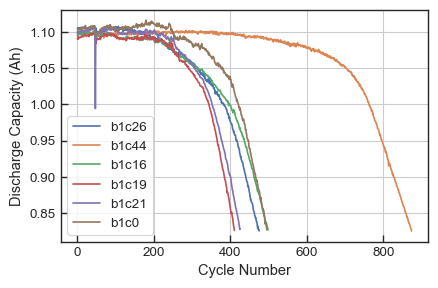

In [ ]:
# Example of discharge fade cell curves.
fig, ax = plt.subplots(figsize=(4.5,3))
random_cells = np.random.choice(list(bat_dict.keys()), 6, replace=False)
for cid in random_cells:
    ax.plot(bat_dict[cid]['summary']['cycle'], 
            bat_dict[cid]['summary']['QD'], 
            label=cid)
ax.set_xlabel('Cycle Number')
ax.set_ylabel('Discharge Capacity (Ah)')
ax.legend(loc='best')
ax.grid(which='major', axis='both')
fig.tight_layout()
plt.show()

In [43]:
# Select a cell ID:
cell = 'b1c20'  # EDIT HERE

In [44]:
xi = bat_dict[cell]['summary']['cycle']  # cycles (index)
qd = bat_dict[cell]['summary']['QD']     # discharge capacity (Ah)

In [45]:
# Smooth data with a Savitzky-Golay filter, after
# removing outliers.
yhat = filter_signal(qd)

In [46]:
low, high = 2, 300  # Linear fit of the filtered data.
a0, ai = interpolate_signal(xi, yhat, low, high)
yi = ai * xi[low:high] + a0

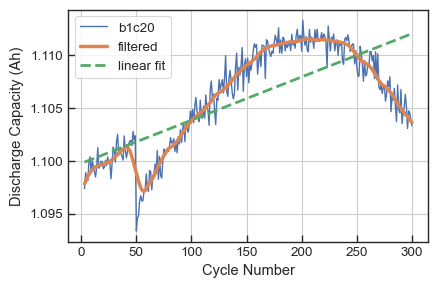

In [ ]:
fig, ax = plt.subplots(figsize=(4.5,3))
ax.plot(xi[low:high], qd[low:high], lw=1, label=cell)
ax.plot(xi[low:high], yhat[low:high], lw=2.5, label='filtered')
ax.plot(xi[low:high], yi, ls='--', lw=2, label='linear fit')
ax.set_xlabel('Cycle Number')
ax.set_ylabel('Discharge Capacity (Ah)')
ax.grid(which='major', axis='both')
ax.legend(loc='best')
fig.tight_layout()
plt.show()

### Bacon-Watts models

In [18]:
# Bacon-Watts model (knee-point detection).
p0_single = [1, -1e-4, -1e-4, 0.7*len(yhat)]
popt_single, confint_single = fit_bacon_watts_model(xi, yhat, p0_single, 
                                                    model_type='single')
print('Knee point at cycle:', int(popt_single[3]))

# Double Bacon-Watts model (knee-point onset prediction).
p0 = [popt_single[0], popt_single[1] + popt_single[2]/2, popt_single[2], 
      popt_single[2]/2, 0.8*popt_single[3], 1.1*popt_single[3]]
popt, confint = fit_bacon_watts_model(xi, yhat, p0, model_type='double')
print('Knee point onset at cycle:', int(popt[4]))

Knee point at cycle: 394
Knee point onset at cycle: 303


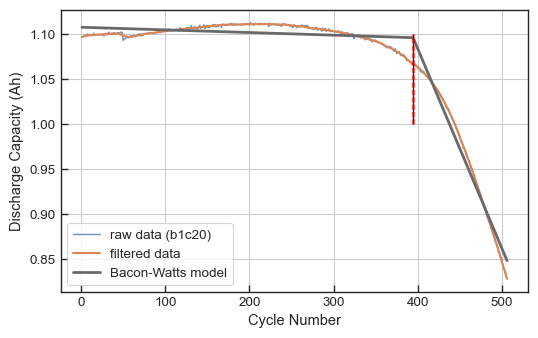

In [19]:
fig, ax = plt.subplots(figsize=(5.5,3.5))
ax.plot(xi, qd, lw=1, alpha=0.8, label=f'raw data ({cell})')
ax.plot(xi, yhat, lw=1.5, label='filtered data')
ax.plot(xi, bacon_watts_model(xi, *popt_single), 
        c='dimgrey', lw=2, label='Bacon-Watts model')
ax.vlines(popt_single[3], 1, 1.1, color='darkred', lw=1)
ax.vlines(confint_single[0], 1, 1.1, color='red', alpha=0.5, lw=1, ls='--')
ax.vlines(confint_single[1], 1, 1.1, color='red', alpha=0.5, lw=1, ls='--')
ax.set_xlabel('Cycle Number')
ax.set_ylabel('Discharge Capacity (Ah)')
ax.grid(which='major', axis='both')
ax.legend(loc='lower left')
fig.tight_layout()
plt.show()

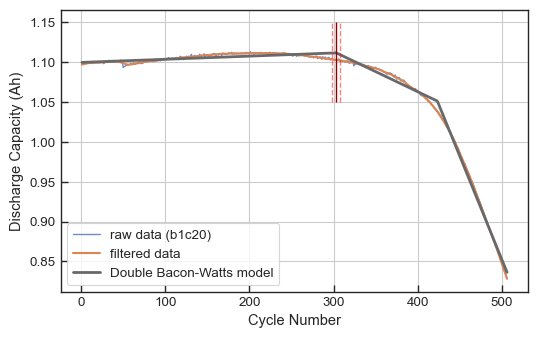

In [20]:
fig, ax = plt.subplots(figsize=(5.5,3.5))
ax.plot(xi, qd, lw=1, alpha=0.8, label=f'raw data ({cell})')
ax.plot(xi, yhat, lw=1.5, label='filtered data')
ax.plot(xi, double_bacon_watts_model(xi, *popt), 
        c='dimgrey', lw=2, label='Double Bacon-Watts model')
ax.vlines(popt[4], 1.05, 1.15, color='darkred', lw=1)
ax.vlines(confint[0], 1.05, 1.15, color='red', alpha=0.5, lw=1, ls='--')
ax.vlines(confint[1], 1.05, 1.15, color='red', alpha=0.5, lw=1, ls='--')
ax.set_xlabel('Cycle Number')
ax.set_ylabel('Discharge Capacity (Ah)')
ax.legend(loc='lower left')
ax.grid(which='major', axis='both')
fig.tight_layout()
plt.show()

### Processing of cycles data

Showing different cell measurements, with examples of processing cycles data.

In [21]:
# Select a number of cycles to process:
no_cycles = 5   # EDIT HERE
cell_stats = get_cell_stats(bat_dict, cell, no_cycles, 'Qdlin')
print(cell_stats)

defaultdict(<class 'list'>, {'min': [0.0, 0.0, 0.0, 0.0], 'max': [1.0591915103376703, 1.0589397401753748, 1.059299027929643, 1.059570494827653], 'mean': [0.7610900167775188, 0.7573694632822529, 0.7587263133248223, 0.7604885859657009], 'std': [0.42315665843588207, 0.42320779292195687, 0.4246735063501693, 0.4228904781481538], 'mode': [1.0591915103376703, 1.0589397401753748, 1.059299027929643, 1.059570494827653], 'skew': [-1.0487863523203715, -1.0338418626946022, -1.0369301966832944, -1.0468068232964876], 'kurt': [-0.7316514406926782, -0.7586063971590606, -0.7609247135175274, -0.7328870117268158], 'median': [1.0235131501277488, 1.0204676144543665, 1.0224975522514237, 1.0225077128346607], 'iqr': 0.5998422256471136, 'auc': [1.1419826141476723, 1.1363963865047522, 1.1384334291454317, 1.1410792803577883]})


In [22]:
v = bat_dict[cell]['Vdlin']  # voltage
t10 = bat_dict[cell]['cycles'][str(10)]['t']
IR10 = bat_dict[cell]['cycles'][str(10)]['I']
t100 = bat_dict[cell]['cycles'][str(100)]['t']
IR100 = bat_dict[cell]['cycles'][str(100)]['I']
V10 = bat_dict[cell]['cycles'][str(10)]['V']
V100 = bat_dict[cell]['cycles'][str(100)]['V']
V300 = bat_dict[cell]['cycles'][str(300)]['V']
Qd10 = bat_dict[cell]['cycles'][str(10)]['Qdlin']
Qd100 = bat_dict[cell]['cycles'][str(100)]['Qdlin']
Td10 = bat_dict[cell]['cycles'][str(10)]['Tdlin']
Td100 = bat_dict[cell]['cycles'][str(100)]['Tdlin']
dQdV10 = bat_dict[cell]['cycles'][str(10)]['dQdV']
dQdV100 = bat_dict[cell]['cycles'][str(100)]['dQdV']

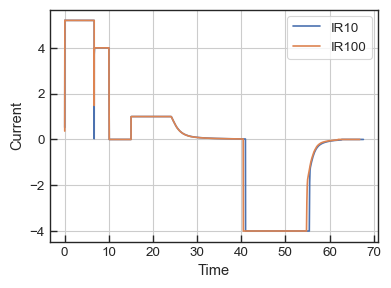

In [23]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(t10, IR10, label='IR10')
ax.plot(t100, IR100, label='IR100')
ax.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('Current')
ax.grid(True)
fig.tight_layout()
plt.show()

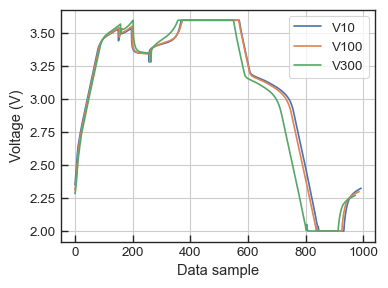

In [83]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(V10, label='V10')
ax.plot(V100, label='V100')
ax.plot(V300, label='V300')
ax.legend(loc='best')
ax.set_xlabel('Data sample')
ax.set_ylabel('Voltage (V)')
ax.grid(True)
fig.tight_layout()
plt.savefig('fig1.png', dpi=300)
plt.show()

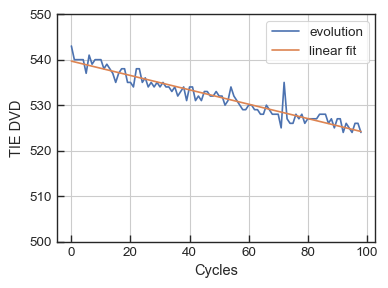

In [ ]:
# Time interval of equal discharge voltage drop (TIE-DVD)
# evolution between cycles 2 and 50 (and its linear fit).
cell_stats_volt = get_cell_stats(bat_dict, cell, 100, 'V')
xvals = np.arange(len(cell_stats_volt['tie-dvd']))
a0, ai = interpolate_signal(xvals, cell_stats_volt['tie-dvd'], 0, -1)
yvals = ai[0]*xvals + a0

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(xvals, cell_stats_volt['tie-dvd'], label='evolution')
ax.plot(xvals, yvals, label='linear fit')
ax.legend(loc='best')
ax.set_xlabel('Cycles')
ax.set_ylabel('TIE DVD')
ax.grid(True)
fig.tight_layout()
plt.savefig('fig2.png', dpi=300)
plt.show()

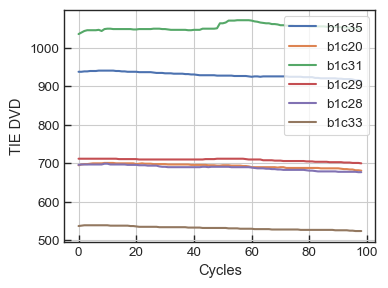

In [ ]:
fig, ax = plt.subplots(figsize=(4,3))
xs = np.asarray([i for i in range(10, 100, 4)])
random_cells = np.random.choice(list(bat_dict.keys()), 6, replace=False)
a0s, ais = [], []
for cell in random_cells:
    cell_stats_volt = get_cell_stats(bat_dict, cell, 100, 'V')
    xvals = np.arange(len(cell_stats_volt['tie-dvd']))
    yvals = medfilt(cell_stats_volt['tie-dvd'], kernel_size=21)
    a0, ai = interpolate_signal(xvals, yvals, 0, -1)
    a0s.append(a0)
    ais.append(ai[0])
    ax.plot(xvals, yvals, ls='-', lw=1.5, label=cell)
ax.set_xlabel('Cycles')
ax.set_ylabel('TIE DVD')
ax.legend(loc='best')
ax.grid(True)
fig.tight_layout()
plt.savefig('fig3.png', dpi=300)
plt.show()

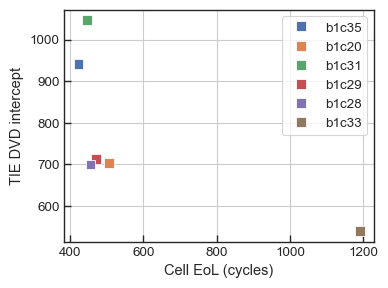

In [81]:
eols = []
for cell in random_cells:
    eol = len(bat_dict[cell]['summary']['QD'])
    eols.append(eol)
data = pd.DataFrame({'x':eols, 'y':a0s, 'cell':random_cells})
fig, ax = plt.subplots(figsize=(4,3))
sns.scatterplot(data, x='x', y='y', hue='cell', marker='s', s=50, ax=ax)
ax.set_xlabel('Cell EoL (cycles)')
ax.set_ylabel('TIE DVD intercept')
ax.legend(loc='best')
ax.grid(True)
fig.tight_layout()
plt.savefig('fig4.png', dpi=300)
plt.show()

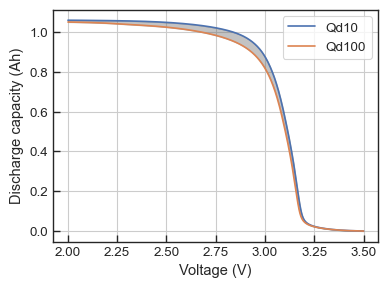

In [44]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(v, Qd10, label='Qd10')
ax.plot(v, Qd100, label='Qd100')
ax.fill_between(v, Qd100, Qd10, color='dimgrey', alpha=0.4)
ax.legend(loc='best')
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Discharge capacity (Ah)')
ax.grid(True)
fig.tight_layout()
plt.savefig('fig1.png', dpi=300)
plt.show()

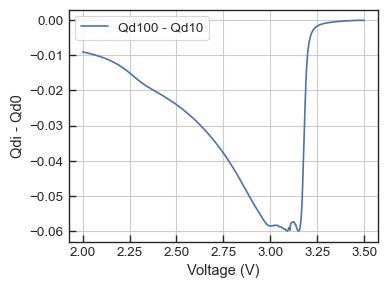

In [45]:
deltaQ = Qd100 - Qd10

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(v, deltaQ, label='Qd100 - Qd10')
ax.legend(loc='best')
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Qdi - Qd0')
ax.grid(True)
fig.tight_layout()
plt.savefig('fig2.png', dpi=300)
plt.show()

In [27]:
# Statistics for the Qd100 - Qd10 curve.
dQ_stats = get_data_array_stats(deltaQ)
dQ_stats

{'min': -0.0599611066808754,
 'max': -5.922018376103576e-05,
 'mean': -0.02568300435634949,
 'std': 0.019774850635291063,
 'mode': -0.0599611066808754,
 'skew': -0.39128017608437793,
 'kurt': -1.1205085945799993,
 'median': -0.02178456313093413,
 'iqr': 0.03176063231807896}

AUC: [-0.0065, -0.0012, 0.0057, 0.0073, 0.0229, 0.025, 0.0239, 0.0334, 0.0382, 0.0501, 0.0518, 0.0739, 0.0818, 0.0912, 0.0938, 0.1003, 0.1156, 0.1226, 0.1262]


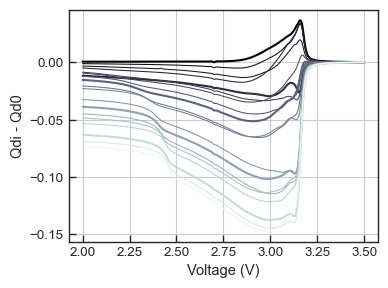

In [46]:
q0 = bat_dict[cell]['cycles'][str(1)]['Qdlin']
start, stop, step = 10, 200, 10
n_steps = int((stop - start)/step) + 1
colors = plt.cm.bone(np.linspace(0, 1, n_steps))
fig, ax = plt.subplots(figsize=(4,3))
aucs = []
k = 0
for i in range(start, stop, step):
    qi = bat_dict[cell]['cycles'][str(i)]['Qdlin']
    deltaQ = qi - q0
    aucs.append(simpson(deltaQ, x=v))
    if i in range(start, stop, 4*step):
        ax.plot(v, deltaQ, c=colors[k], lw=1.5)
    else:
        ax.plot(v, deltaQ, c=colors[k], lw=0.75)
    k += 1
print('AUC:', [a.round(4) for a in aucs])
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Qdi - Qd0')
ax.grid(True)
fig.tight_layout()
plt.savefig('fig3.png', dpi=300)
plt.show()

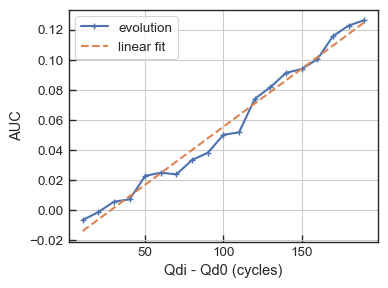

In [47]:
xs = np.asarray([i for i in range(start, stop, step)])
a0, ai = interpolate_signal(xs, aucs, 0, -1)
ys = ai[0]*xs + a0
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(xs, aucs, ls='-', lw=1.5, marker='+', label='evolution')
ax.plot(xs, ys, ls='--', lw=1.5, label='linear fit')
ax.set_xlabel('Qdi - Qd0 (cycles)')
ax.set_ylabel('AUC')
ax.legend(loc='upper left')
ax.grid(True)
fig.tight_layout()
plt.savefig('fig4.png', dpi=300)
plt.show()

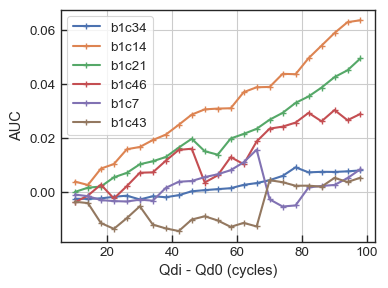

In [74]:
fig, ax = plt.subplots(figsize=(4,3))
xs = np.asarray([i for i in range(10, 100, 4)])
random_cells = np.random.choice(list(bat_dict.keys()), 6, replace=False)
slopes = []
for cell in random_cells:
    _, aucs_cell = process_multiple_deltas(bat_dict, cell, 'Qdlin', 10, 100, 4)
    a0, ai = interpolate_signal(xs, aucs_cell, 0, -1)
    slopes.append(ai[0])
    ax.plot(xs, aucs_cell, ls='-', lw=1.5, marker='+', label=cell)
ax.set_xlabel('Qdi - Qd0 (cycles)')
ax.set_ylabel('AUC')
ax.legend(loc='upper left')
ax.grid(True)
fig.tight_layout()
plt.savefig('fig5.png', dpi=300)
plt.show()

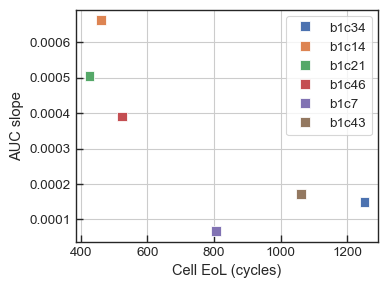

In [75]:
eols = []
for cell in random_cells:
    eol = len(bat_dict[cell]['summary']['QD'])
    eols.append(eol)
data = pd.DataFrame({'x':eols, 'y':slopes, 'cell':random_cells})
fig, ax = plt.subplots(figsize=(4,3))
sns.scatterplot(data, x='x', y='y', hue='cell', marker='s', s=50, ax=ax)
ax.set_xlabel('Cell EoL (cycles)')
ax.set_ylabel('AUC slope')
ax.legend(loc='best')
ax.grid(True)
fig.tight_layout()
plt.savefig('fig6.png', dpi=300)
plt.show()

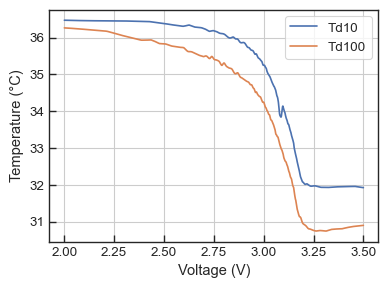

In [29]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(v, Td10, label='Td10')
ax.plot(v, Td100, label='Td100')
ax.legend(loc='best')
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Temperature (°C)')
ax.grid(True)
fig.tight_layout()
plt.show()

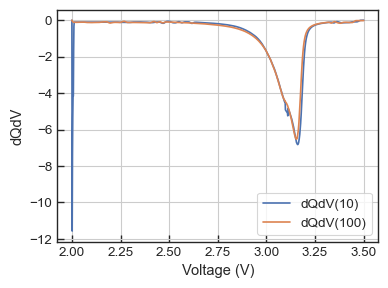

In [30]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(v, dQdV10, label='dQdV(10)')
ax.plot(v, dQdV100, label='dQdV(100)')
ax.legend(loc='best')
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('dQdV')
ax.grid(True)
fig.tight_layout()
plt.show()

In [89]:
# Notebook parameters
# -------------------
# Regression analysis:
targets = 'eol'  # ['eol', 'knee', 'knee-onset']
set_of_features = 'variance'  # ['variance', 'discharge', 'full', 'custom', 'all', '50cycles']
reg = 'lin'  # ['lin', 'gen', 'nusvr', 'svr', 'ard']
reduce_features = False  # [True/False]
n_features = 6  # [number of features to retain]
# Classification analysis:
cls_model = 'logr'  # ['logr', 'svc']

### Regression analysis

Targets of the regression can be: (1) End-of-Life cell points, (2) Knee cell points, or (3) Knee-onset cell points. Knee and knee-onset points are determined using, respectively, single and double Bacon-Watts model fits.

Analysis considers three sets with progressively increasing number of features. First set is called a "variance model" features and considers a single feature. Second set is called "discharge model" features and implements several features derived from cell discharge cycle and fade curves. Third set is called "full model" features and contains the most extensive set. For more information regarding these feature sets consult "Supplementary information" for the Nature Energy paper "Data-driven prediction of battery cycle life before capacity degradation".

Analysis further considers four different regression models, which can be applied with any of the three feature sets. These are (1) Penalized elastic net linear regression, (2) Generalized linear regression with a Tweedie distribution, (3) Nu-Support vector regression and (4) Support vector regression, both with RBF kernels.

#### Features engineering

In [90]:
X_data_dict, y_data_dict = get_features_targets_from_data(
    bat_dict, skip_outliers=False
)

Cell ID: b1c2 cycle 46 Qdlin data out of range.
Cell ID: b1c5 cycle 47 Qdlin data out of range.
Cell ID: b1c10 cycle 46 Qdlin data out of range.
Cell ID: b1c11 cycle 45 Qdlin data out of range.
Cell ID: b1c21 cycle 47 Qdlin data out of range.
Cell ID: b1c22 cycle 36 Qdlin data out of range.
Skipping cell ID: b1c37 with EoL: 101.
Skipping cell ID: b1c38 with EoL: 101.
Cell ID: b1c40 cycle 26 dQdV data out of range.
Cell ID: b1c40 cycle 38 dQdV data out of range.
Cell ID: b1c41 cycle 24 dQdV data out of range.
Cell ID: b1c41 cycle 27 dQdV data out of range.
Cell ID: b1c41 cycle 28 dQdV data out of range.
Cell ID: b1c41 cycle 33 dQdV data out of range.
Cell ID: b1c41 cycle 37 dQdV data out of range.
Cell ID: b1c41 cycle 38 dQdV data out of range.
Cell ID: b1c41 cycle 47 dQdV data out of range.
Cell ID: b1c42 cycle 34 dQdV data out of range.
Cell ID: b1c42 cycle 45 dQdV data out of range.
Cell ID: b1c42 cycle 46 dQdV data out of range.
Cell ID: b1c44 cycle 20 dQdV data out of range.
Cell I

In [33]:
# All feature names.
print(X_data_dict.keys())

dict_keys(['class_min', 'class_std', 'min', 'mean', 'std', 'mode', 'skew', 'kurt', 'iqr', 'qd2', 'qd_dif', 'qd100', 'slope', 'inter', 'slp9', 'inc9', 'char5', 'tsmin', 'tsmax', 't_int', 'rsmin', 'rsdif', 'dq_auc', 'dqdv_min', 'dqdv_mean', 'dqdv_std', 'dqdv_mode', 'dqdv_skew', 'dqdv_kurt', 'dqdv_iqr', 'dqdv_auc', 'td_min', 'td_mean', 'td_std', 'td_mode', 'td_skew', 'td_kurt', 'td_iqr', 'td_auc', 'tav5', 'tadif', 'tie-dvd', 'auc50q', 'auc_d', 'auc_a0', 'auc_ai', 'mod50', 'auc50', 'auc50qv', 'auc_dqv', 'md_qv', 'auc_a0qv', 'auc_aiqv', 'tie_a0', 'tie_ai'])


In [91]:
# The `targets` parameter can have following values:
#     'eol': End-of-Life values,
#     'knee': Knee point values (from the single Bacon-Watts model fit),
#     'knee-onset': Knee-onset values (from the double Bacon-Watts model fit).
y_data = y_data_dict[targets]

In [92]:
# Correlations between features and log of targets.
vif = []  # very important feature
pcf = []  # pearson correlation
for key in X_data_dict.keys():
    p, _ = pearsonr(X_data_dict[key], np.log10(y_data))
    pcf.append(p)
    # Print only significant correlations.
    if p < -0.5 or p > 0.5:
        print(f'{key}: {p:.3f}')
        vif.append(key)

min: 0.794
mean: 0.779
std: -0.837
mode: 0.794
iqr: -0.892
dq_auc: -0.779
dqdv_kurt: 0.548
dqdv_iqr: -0.741
tie-dvd: -0.583
auc50q: 0.739
auc_d: -0.627
auc_ai: 0.714
mod50: 0.652
auc50: -0.644
auc_dqv: -0.571
auc_aiqv: -0.661
tie_a0: -0.579


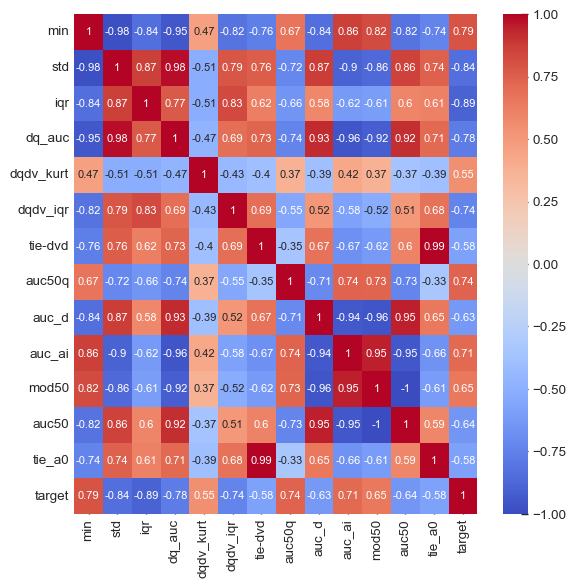

In [99]:
df = pd.DataFrame(X_data_dict, columns=vif)
df.drop(columns=['mean', 'mode', 'auc_dqv', 'auc_aiqv'], inplace=True)
df['target'] = np.log10(y_data)
pearson_matrix = df.corr('pearson')
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(pearson_matrix, annot=True, annot_kws=dict(size=8), 
            vmin=-1, vmax=1, cmap=plt.cm.coolwarm, ax=ax)
plt.tight_layout()
plt.show()

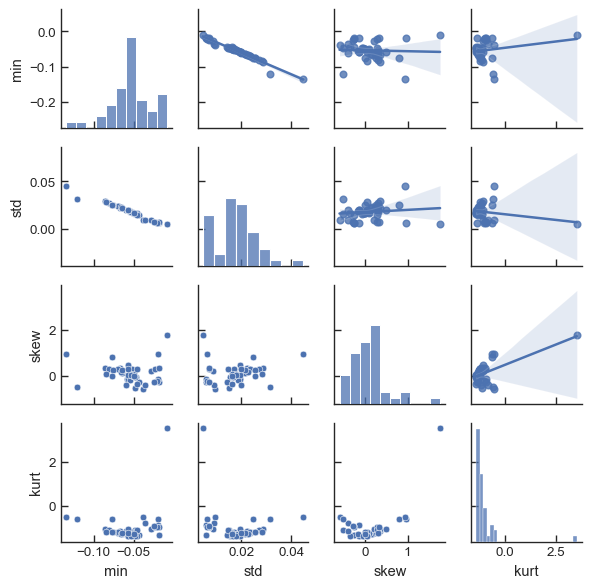

In [108]:
# Pairplot of important features.
df = pd.DataFrame(X_data_dict, columns=['min', 'std', 'skew', 'kurt'])
g = sns.PairGrid(data=df, height=1.5)
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot)
g.map_upper(sns.regplot)
plt.savefig('pairgrid.png', dpi=600)
plt.show()

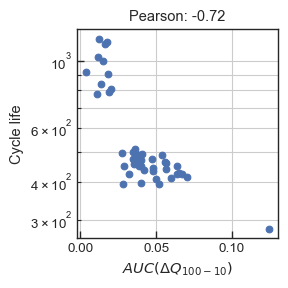

In [37]:
# Example:
fig, ax = plt.subplots(figsize=(3,3))
# Pearson's correlation coefficient.
rho, _ = pearsonr(X_data_dict['dq_auc'], y_data)
ax.set_title(f'Pearson: {rho:.2f}')
ax.set_yscale('log')
ax.scatter(X_data_dict['dq_auc'], y_data)
ax.set_xlabel(r'$AUC(\Delta Q_{100-10})$')
ax.set_ylabel('Cycle life')
ax.grid(which='both', axis='both')
fig.tight_layout()
plt.show()

#### "Variance model" features

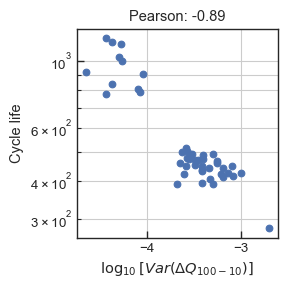

In [ ]:
# Model has a single feature, which is the variance of the 
# difference between discharge curves for the 10-th and the 100-th
# cycles, i.e. Var(Q100 - Q10).
if set_of_features == 'variance':
    X_data = np.log10(np.asarray(X_data_dict['std'])**2).reshape(-1, 1)
    
    # Pearson's correlation coefficient.
    rho, _ = pearsonr(X_data.flatten(), y_data)

    fig, ax = plt.subplots(figsize=(3,3))
    ax.set_title(f'Pearson: {rho:.2f}')
    ax.set_yscale('log')
    ax.scatter(X_data, y_data)
    ax.set_xlabel(r'$\log_{10}[Var(\Delta Q_{100-10})]$')
    ax.set_ylabel('Cycle life')
    ax.grid(which='both', axis='both')
    fig.tight_layout()
    plt.savefig('log_var_dq.png', dpi=600)
    plt.show()

##### Classical OLS regression (variance feature)

In [39]:
exog = sm.add_constant(X_data)  # add intercept
# Ordinary least-squares regression.
ols_model = sm.OLS(np.log10(y_data), exog)
ols_results = ols_model.fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     227.7
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           8.69e-19
Time:                        10:02:15   Log-Likelihood:                 62.690
No. Observations:                  45   AIC:                            -121.4
Df Residuals:                      43   BIC:                            -117.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6160      0.074     21.759      0.0

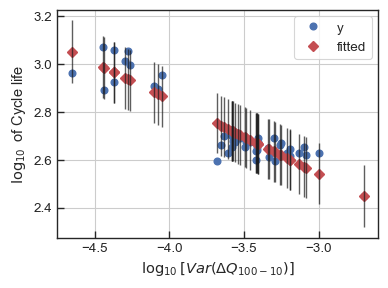

In [40]:
fig, ax = plt.subplots(figsize=(4,3))
sm.graphics.plot_fit(ols_results, 1, ax=ax)
ax.set_title('')
ax.set_xlabel(r'$\log_{10}[Var(\Delta Q_{100-10})]$')
ax.set_ylabel(r'$\log_{10}$'+' of Cycle life')
ax.grid(which='both', axis='both')
fig.tight_layout()
plt.show()

##### Classical GLM (Gamma + Log link) regression (variance feature)

In [41]:
# Generalized linear model with a Gamma distribution and a log link.
glm_model = sm.GLM(np.log10(y_data), exog, 
                   family=sm.families.Gamma(link=sm.families.links.Log()))
glm_results = glm_model.fit()
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   45
Model:                            GLM   Df Residuals:                       43
Model Family:                   Gamma   Df Model:                            1
Link Function:                    Log   Scale:                      0.00046897
Method:                          IRLS   Log-Likelihood:                 64.436
Date:                Tue, 29 Apr 2025   Deviance:                     0.020237
Time:                        10:02:16   Pearson chi2:                   0.0202
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9952
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6035      0.026     23.066      0.0

#### "Discharge model" features

In [42]:
# Model usues a combination of statistical features from the deltaQ
# curve (see above) and the battery cell discharge fade curve.
if set_of_features == 'discharge':
    selected_features = ['std', 'min', 'skew', 'kurt', 'qd2', 'qd_dif']

#### "Full model" features

In [43]:
# Model uses a more extensive set of engineered features.
if set_of_features == 'full':
    selected_features = ['std', 'min', 'qd2', 'slope', 'inter', 
                         'char5', 't_int', 'rsmin', 'rsdif']

#### "Custom model" features

In [ ]:
# My custom models.
if set_of_features == 'custom':
    selected_features = ['min', 'std', 'kurt', 'iqr', 'tie-dvd',
                         'dq_auc', 'auc50q', 'auc_d', 'auc_ai']
if set_of_features == '50cycles':
    selected_features = ['auc50q', 'auc_d', 'auc_ai', 'auc50qv', 
                         'auc_dqv', 'auc_aiqv', 'mod50', 'auc50']

In [45]:
if set_of_features == 'all':
    # Using all derived features.
    X_data = pd.DataFrame(X_data_dict)
    # Remove classification features.
    X_data.drop(columns=['class_min', 'class_std'], inplace=True)
    # Edit feature.
    X_data['std'] = np.log10(X_data['std'].values**2)
elif set_of_features in ['discharge', 'full', 'custom']:
    # Using only selected features.
    X_data = pd.DataFrame(X_data_dict, columns=selected_features)
elif set_of_features == 'variance':
    pass
else:
    raise NotImplementedError(f'Model: {set_of_features} is not recognized!')

#### Train & test split

In [46]:
# Split dataset into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, train_size=0.8,  # 80% train
    shuffle=True
)

In [47]:
if reg == 'lin':
    # Penalized linear regression.
    model_name = 'ElasticNet'
    reg_model = ElasticNet(max_iter=10_000)
elif reg == 'gen':
    # Generalized linear regression with a Tweedie distribution.
    model_name = 'TweedieRegressor'
    reg_model = TweedieRegressor(max_iter=1000)
elif reg == 'nusvr':
    # Nu-Support Vector Machine regression.
    model_name = 'NuSVR'
    reg_model = svm.NuSVR(kernel='rbf')
elif reg == 'svr':
    # Support Vector Machine regression.
    model_name = 'SVR'
    reg_model = svm.SVR(kernel='rbf')
elif reg == 'ard':
    # Relevance Vector Machine regression.
    model_name = 'ARD'
    reg_model = ARDRegression()
else:
    raise NotImplementedError(f'Model {reg} is not recognized.')

#### GridSearchCV hyperparameters optimization 

In [48]:
# Get a fixed grid of hyperparameter values.
grid = get_grid_values(reg)

# Hyperparameters optimization with grid search and cross-validation.
grid_search = GridSearchCV(estimator=reg_model, param_grid=grid, 
                           scoring='neg_root_mean_squared_error', 
                           cv=3, refit=True, n_jobs=-1)
# Pipeline.
if reduce_features:
    model = Pipeline([
        ('scale', StandardScaler()),
        # Recursive features elimination.
        ('selct', RFE(estimator=svm.SVR(kernel='linear'), 
                      n_features_to_select=n_features)),
        ('model', grid_search)
    ])
else:
    model = Pipeline([
        ('scale', StandardScaler()),
        ('model', grid_search)
    ])

#### Model fit & predict

In [49]:
model.fit(X_train, np.log10(y_train))  # fit on log10 of targets

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 GridSearchCV(cv=3, estimator=ElasticNet(max_iter=10000),
                              n_jobs=-1,
                              param_grid={'alpha': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                                          'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95,
                                                       0.99, 1]},
                              scoring='neg_root_mean_squared_error'))])

In [50]:
model['model'].best_params_

{'alpha': 0.001, 'l1_ratio': 0.1}

In [51]:
# Predicted values.
y_pred = model.predict(X_test)
y_pred = 10**y_pred  # return back to targets
print(y_pred.round(0))

[1143.  396.  403.  468.  510.  397.  464.  482.  933.]


In [52]:
# Actual values.
print(y_test)

[ 920  412  423  396  493  442  474  471 1152]


In [ ]:
# Plot observed against predicted cycle lives,
# along with model residuals.
fig, ax = plt.subplots(figsize=(3.5,3.5))
ax.plot([0, 1], [0, 1], ls='--', c='black',  # diagonal line
        transform=ax.transAxes)
ax.scatter(y_test, y_pred, marker='s', s=20)
ax.set_xlabel('Observed EoL')
ax.set_ylabel('Predicted EoL')
axi = fig.add_axes([0.6, 0.25, 0.25, 0.25])
axi.hist(y_test-y_pred, color='dimgrey')
fig.tight_layout()
plt.savefig(f'{reg}_res.png', dpi=300)
plt.show()

#### RMSE and MAPE

In [53]:
rmse = root_mean_squared_error(y_test, y_pred)
print(f'RMSE (test): {rmse:.2f} cycles')

RMSE (test): 108.52 cycles


In [54]:
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE (test): {mape*100:.2f} %')

MAPE (test): 9.78 %


#### Run regression multiple times

In [ ]:
# Running the regression analysis multiple times 
# to acquire summary performance statistics.
num_runs = 5
rmse, mape = [], []
for i in range(num_runs):
    r, m = run_regression(reg, X_data, y_data,
                          reduce_features=reduce_features, 
                          n_features=n_features)
    rmse.append(r)
    mape.append(m)

print(f'Test errors from {num_runs} runs ({model_name}):')
print(f'RMSE: {np.mean(rmse):.2f} +/- {np.std(rmse):.2f} cycles')
print(f'MAPE: {np.mean(mape):.2f} +/- {np.std(mape):.2f} %')

Test errors from 5 runs (ElasticNet):
RMSE: 98.39 +/- 29.16 cycles
MAPE: 11.24 +/- 2.54 %


#### SHAP analysis

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

In [56]:
# SHAP analysis (optional):
shap_analysis = False

In [ ]:
if reg == 'lin':
    # Penalized linear regression.
    final_model = ElasticNet(**model['model'].best_params_)
elif reg == 'gen':
    # Generalized linear regression with a Tweedie distribution.
    final_model = TweedieRegressor(**model['model'].best_params_)
elif reg == 'nusvr':
    # Nu-Support Vector Machine regression.
    final_model = svm.NuSVR(kernel='rbf', **model['model'].best_params_)
elif reg == 'svr':
    # Support Vector Machine regression.
    final_model = svm.SVR(kernel='rbf', **model['model'].best_params_)
elif reg == 'ard':
    # Relevance Vector Machine regression.
    final_model = ARDRegression(**model['model'].best_params_)
else:
    raise NotImplementedError('Chosen model is not implemented.')

# Refit final model for explaining (with optimal hyperparameters).
final_model.fit(X_train, np.log10(y_train))

ElasticNet(alpha=0.001, l1_ratio=0.1)

In [58]:
if shap_analysis:
    # Create a general Explainer instance from the model (using training data).
    explainer = shap.KernelExplainer(final_model.predict, X_train)

In [59]:
if shap_analysis:
    # Feature importance (average from the test set).
    shap.plots.bar(explainer(X_test), max_display=8)

In [60]:
if shap_analysis:
    # Individual features importance from the test set.
    shap.plots.beeswarm(explainer(X_train), max_display=8)

In [61]:
if shap_analysis:
    shap.plots.waterfall(explainer(X_test)[0])  # explaining the first test sample

### Classification analysis

Classification employs only two features from the Qd(5) - Qd(4) delta curve's statistical features, as proposed in the paper "Data-driven prediction of battery cycle life before capacity degradation".

Class labels are here coded as follows: 0 - long life cell, 1 - short life cell. 
Life threshold was set at 550 cycles.

Following two binary classifiers have been implemented: (1) Logistic regression and (2) Support vector machine with a RBF kernel.

In [62]:
y_data = y_data_dict['class']  # labels
pct_short_life = (sum(y_data == 1) / len(y_data))*100.
print(f'Short life cells: {pct_short_life:.1f} %')

Short life cells: 75.6 %


In [63]:
# Select a set of features for the binary classifier.
selected_features = ['class_std', 'class_min']
X_data = pd.DataFrame(X_data_dict, columns=selected_features)
X_data['class_std'] = X_data['class_std'].values**2  # variance
X_data.head()

,class_std,class_min
0,2.644636e-05,-0.000087
1,3.164396e-07,-0.001705
2,6.706244e-06,-0.002299
3,3.734236e-06,-0.008936
4,1.346046e-05,-0.012777


In [64]:
# Split dataset into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, train_size=0.7,  # 70% train
    shuffle=True, stratify=y_data
)

In [65]:
if cls_model == 'logr':
    # Logistic regression binary classifier.
    estimator = LogisticRegression()
    grid = {'C': [1, 10, 50, 100],
            'class_weight': ['balanced', None]}
elif cls_model == 'svc':
    # Support vector machine binary classifier with a RBF kernel.
    estimator = svm.SVC(kernel='rbf')
    grid = {'gamma': ['scale', 'auto'],
            'C': [1, 10, 50, 100],
            'class_weight': ['balanced', None]}
else:
    raise NotImplementedError('Chosen model is not implemented.')

In [66]:
# Hyperparameters optimization with grid search and cross-validation.
grid_search = GridSearchCV(estimator=estimator, param_grid=grid, 
                           scoring='roc_auc',  # area under the ROC curve
                           cv=2, refit=True, 
                           n_jobs=-1)
# Pipeline.
model = Pipeline([
    ('scale', StandardScaler()),
    ('model', grid_search)
])

In [67]:
model.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 GridSearchCV(cv=2, estimator=LogisticRegression(), n_jobs=-1,
                              param_grid={'C': [1, 10, 50, 100],
                                          'class_weight': ['balanced', None]},
                              scoring='roc_auc'))])

In [68]:
model['model'].best_params_

{'C': 10, 'class_weight': 'balanced'}

In [69]:
# Predicted values.
y_pred = model.predict(X_test)
y_pred

array([0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0])

In [70]:
y_test

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1])

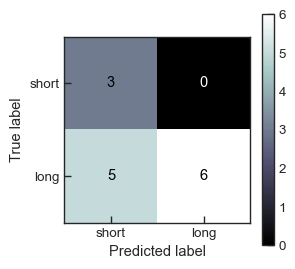

In [71]:
# Confusion matrix.
fig, ax = plt.subplots(figsize=(3,3))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, 
    display_labels=['short', 'long'],
    cmap='bone',
    ax=ax
)
plt.show()

In [72]:
# Classification report.
print(classification_report(y_test, y_pred, 
                            target_names=['short', 'long'],
                            zero_division=0))

              precision    recall  f1-score   support

       short       0.38      1.00      0.55         3
        long       1.00      0.55      0.71        11

    accuracy                           0.64        14
   macro avg       0.69      0.77      0.63        14
weighted avg       0.87      0.64      0.67        14

